In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import os

%matplotlib inline

In [2]:
curdir = os.getcwd()

In [3]:

os.chdir("../../core/")
import GT_helper_functions as hf
import GT_load_data as data

os.chdir(curdir)

In [4]:
fullIndex = data.munisGT[(data.munisGT.municode != 0) & data.munisGT.deptocode.notna()]\
.assign(deptocode = lambda x: x.deptocode.astype(int)).groupby(["deptocode", "municode"]).apply(len).index

In [5]:
def makeFullIndex(dfyears):
    indexList = fullIndex.to_list()
    newIndex = []
    for year in dfyears.index.levels[0]:
        newIndex.extend([(year, x[0], x[1]) for x in indexList])
    return dfyears.reindex(pd.MultiIndex.from_tuples(newIndex, names = ["date", "department", "municipality"]), fill_value=0)

In [6]:
def tryfun(f):
    def wrapper(i):
        try:
            return f(i)
        except:
            return np.NaN
    return wrapper

# Outputs


In [7]:
notifs = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Notificaciones TB/GTM - TB all notifications 2012-Sep2018.csv")

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (7,8,9,11,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,72,74,78,79,80,81,83,84,85,87,89,90,91,93,94,98,102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
notifs.loc[notifs.COD_MUNI == 1422, "COD_MUNI"] = 1420

In [9]:
notifs["Year"] = np.floor(notifs.YearMonth/100)

In [10]:
casesNotif = notifs[(notifs.Year<2018) & notifs.COD_MUNI.notna()].assign(municipality = lambda x: x.COD_MUNI).assign(date=lambda x: x.Year.astype(int))\
.assign(department = lambda x: (np.floor(x.COD_MUNI/100)).astype(int) ).groupby(["date", "department", "municipality"]).apply(len)

In [11]:
casesNotif = casesNotif[casesNotif.index.get_level_values(1)!=0].rename("Cases Notified_value_m").fillna(0)

In [12]:
extraM2017 = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Extramuros2017.csv", index_col=0)

In [13]:
acfcases = extraM2017[extraM2017.Year.notna()].assign(municipality = lambda x: x.MuniCode.astype(int)).assign(date = lambda x: x.Year.astype(int)).\
assign(department = lambda x: x.DeptoCode.astype(int)).groupby(["date", "department", "municipality"])["bacteriologicos.extramuros"].sum()
acfcases = acfcases.rename("Additional Cases Detected via ACF_value_m").fillna(0)

In [14]:
#acfcases = acfcases.reindex(casesNotif.index)

In [15]:
# Cases Started on Treatment_value
# MDR Cases Started Treatment_value

cohortes = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/GTM - Tx cohort data 2012-2016.csv")

In [16]:
cohortes.head()

,Unnamed: 0,col_name,deptocode,row_name,row_name_B,table,value,year
0,0,I TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Genexpert,6.0,2016
1,1,II TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Genexpert,7.0,2016
2,2,III TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Genexpert,4.0,2016
3,3,IV TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Genexpert,8.0,2016
4,4,TOTAL,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Genexpert,25.0,2016


In [17]:
pivot_cohortes = cohortes[(cohortes.col_name.isin(["TOTAL"])) & 
       (cohortes.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", "Nuevos Pediatricos", 
                          "Nuevos Extrapulmonares", "Nuevos TB/VIH", "Retratamiento"])) &
       (cohortes.deptocode!=0)].\
    groupby(["year", "deptocode", "row_name_B"]).value.sum().unstack(2)

In [18]:
pivot_cohortes.head()

row_name_B      COMPLETED TREATMENT  DEATHS  LOST TO FOLLOW-UP  REFERRED
year deptocode                                                          
2012 1                        594.0    28.0               23.0       3.0
     2                         21.0     4.0                1.0       0.0
     3                         39.0     0.0                0.0       0.0
     4                         31.0     4.0                0.0       1.0
     5                        508.0    43.0               43.0       9.0

In [19]:
initiatedTx = pivot_cohortes.sum(axis=1)

In [20]:
initiatedTx = initiatedTx.rename_axis(index = { "year": "date", "deptocode": "department" }).rename("Cases Started on Treatment_value_d")

In [21]:
notifs["Tx"] = notifs.FECHAINICIOTX.map(lambda x: len(str(x))>4)

In [22]:
notifs.groupby("YEAR")["Tx"].sum()

YEAR
2012    2368.0
2013    2394.0
2014    2644.0
2015    2500.0
2016    2758.0
2017    3990.0
2018    3003.0
Name: Tx, dtype: float64

In [23]:
initiatedTx.reset_index().groupby("date")["Cases Started on Treatment_value_d"].sum()

date
2012    3647.0
2013    3472.0
2014    3262.0
2015    3449.0
2016    3286.0
Name: Cases Started on Treatment_value_d, dtype: float64

In [24]:
# Arriba se muestra que los conteos de las cohortes no encajan con los conteos de los que reciben tratamiento según las notificaciones.
# Se podría deber a que hay personas que reciben tratamiento pero abandonan antes de que se registren en las cohortes
# O podría ser que fueron notificados en un año pero se integraron en la cohorte en el siguiente año. 
# Sin embargo, las notificaciones muestran conteos muy bajos 

In [25]:
initiatedTx2 = initiatedTx.reindex(casesNotif.index).fillna(0)

In [26]:
# Reindex is not bad in this case??
initiatedTx.sum(), initiatedTx2.groupby([initiatedTx2.index.get_level_values(0), initiatedTx2.index.get_level_values(1)]).first().sum()

(17116.0, 17116.0)

In [27]:
tbquimio = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Notificaciones TB/GTM - TB quimio 2012-Sep2018.csv",
                     index_col = 0, low_memory = False)

In [28]:
tbquimio.head()

,NOMBRES,DIRECCION,MUNICIPIO,DEPARTAMENTO,SERVICIODESALUD,SEXO,EDAD,RANGOEDAD,PESOLBS,PESOKG,...,CONTROL7_GX,OBSERVACIONES,PRIORIZACION,PESOLB,NotificationDate,YearMonth_,DEPTO_CORRECTED,i,COD_DEPT,COD_MUNI
1,NaN,NaN,GRANADOS,BAJA VERAPAZ,"CS, GRANADOS",f,1.0,000 - 004,13.4,6.0909090909090908,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,165,15,1505
2,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",f,8.0,005 - 009,50.8,23.090909090909086,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,167,15,1501
3,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",m,5.0,005 - 009,35,15.909090909090908,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,168,15,1501
4,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",m,6.0,005 - 009,36,16.363636363636363,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,169,15,1501
5,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",m,2.0,000 - 004,24.8,11.272727272727272,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,170,15,1501


In [29]:
tbquimio["Year"] = np.floor(tbquimio.YearMonth/100)

In [30]:
plhivipt= tbquimio[tbquimio.VIH=="Reactive"].assign(department = lambda x: np.floor(x.COD_MUNI/100))\
.groupby(["Year", "department", "COD_MUNI"]).apply(len)

In [31]:
plhivipt.index.levels

FrozenList([[2012.0, 2013.0, 2014.0, 2015.0, 2016.0], [0.0, 1.0, 3.0, 5.0, 8.0, 9.0, 11.0, 12.0, 22.0], [0, 101, 108, 116, 306, 501, 503, 506, 511, 805, 902, 920, 924, 1102, 1105, 1106, 1108, 1109, 1215, 1218, 1225, 2205, 2207]])

In [32]:
plhivipt = plhivipt.rename("PLHIV started on IPT_value_m").fillna(0)\
.rename_axis(index={"Year": "date", "COD_MUNI": "municipality"}) #.reindex(casesNotif.index)

In [33]:
# This is only contacts in notifications database. I am not sure if its ok.

In [34]:
childipt= tbquimio[(tbquimio.Year<2018) & (tbquimio.EDAD <= 5)].assign(department = lambda x: np.floor(x.COD_MUNI/100))\
.groupby(["Year", "department", "COD_MUNI"]).apply(len).rename("Children in Contact with TB Started IPT_value_m")

In [35]:
childipt = childipt.rename_axis(index={"Year": "date", "COD_MUNI": "municipality"}) #.reindex(casesNotif.index)

In [36]:
# Cases Notified in Prisons_value
pplcases = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Prisoners/PPL-conteos-2014-2017.csv", index_col=0)

In [37]:
pplcases = pplcases.assign(department = lambda x : np.floor(x.municipio/100))\
.assign(municipio = lambda y: y.municipio.astype(int)).rename(columns=\
{"n": "Cases Notified in Prisons_value", "YEAR": "date", "municipio": "municipality"})\
.set_index(["date", "department", "municipality"])

In [38]:
#pplcases = pplcases.reindex(casesNotif.index)

In [39]:
ppldata = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Prisoners/tb-ppl-2014-2017.csv")

In [40]:
ppldata["TXDATE"] = pd.to_datetime(ppldata.TXDATE, errors="coerce")

In [41]:
# Sólo una persona no recibió tratamiento.
ppldata.TXDATE.isna().sum()

1

In [42]:
ppltx = ppldata[ppldata.TXDATE.notna()].assign(department = lambda x: np.floor(x.municode.astype(int)/100).astype(int) )\
.assign(date = lambda x: x.YEAR)\
.groupby(["date", "department" , "municode"]).apply(len)\
.rename_axis(index={"municode": "municipality"})\
.rename("Cases Started on Treatment in Prisons_value_m")

In [43]:
ppltx = ppltx[ppltx.index.get_level_values("date")>2012]
ppltx

date  department  municipality
2014  1           101             17
                  113              5
      5           501             44
      6           601              1
      9           901              4
      18          1801            13
      19          1901             4
2015  1           101             20
                  113              7
      5           501             49
      9           901              5
      10          1001             1
      18          1801            29
2016  1           101             39
                  113             11
      5           501             54
      9           901             11
      17          1701             1
      18          1801            39
      19          1901             1
2017  1           101             41
                  113             27
      5           501             57
      6           601              4
      9           901              6
      10          1001            24
      1

In [44]:
# Lets see in the cohort data:
hivyear_A = cohortes[(cohortes.col_name.isin(["TOTAL"])) & 
       (cohortes.table.isin(["Nuevos TB/VIH"])) &
       (cohortes.deptocode==0)].groupby("year").value.sum()
hivyear_A

year
2012    269.0
2013    226.0
2014    197.0
2015    173.0
2016    163.0
Name: value, dtype: float64

In [45]:
# Now with notifications data:
hivyear_B = notifs.groupby(["YEAR", "VIH"]).apply(len).unstack(1)["Reactive"]
hivyear_B

YEAR
2012    289.0
2013    277.0
2014    264.0
2015    201.0
2016    257.0
2017    243.0
2018    157.0
Name: Reactive, dtype: float64

In [46]:
# HIV counts per year, from cohort and from notifications seems to be worse than in previous years
# This may be interpreted as the percentage of HIV cases that received treatment.
hivyear_A/hivyear_B

2012    0.930796
2013    0.815884
2014    0.746212
2015    0.860697
2016    0.634241
2017         NaN
2018         NaN
dtype: float64

In [47]:
# The actual data to integrate into the tables:
# HIV/TB Cases Notified_value

hivcases = notifs[(notifs.VIH == "Reactive") & (notifs.Year<2018) & notifs.COD_MUNI.notna()]\
.assign(municipality = lambda x: x.COD_MUNI.astype(int)).assign(date=lambda x: x.Year.astype(int))\
.assign(department = lambda x: (np.floor(x.COD_MUNI/100)).astype(int) ).groupby(["date", "department", "municipality"]).apply(len)\
.rename("HIV/TB Cases Notified_value_m")

In [48]:
# Now looking at MDR data in notifications:
notifs[notifs.DBCATEGORY=="MDR"].YEAR.value_counts()

2017    95
2018    28
Name: YEAR, dtype: int64

In [49]:
# There is actually a MDR table with all available cohort data:
mdrtb = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/GTM - TB MDR Cohort Data 2014-2016.csv")

In [50]:
mdrtb.head()

,Unnamed: 0,ID,X_0,Gender,Age,X_1,Muni,Depto,DAS,PxNew,...,TxDate_,TxDate_Year,DxDate_,DxDate_Year,ExitDate_,ExitDate_Year,PDSDate_,PDSDate_Year,GxDate_,deptocode
0,0,1.0,0.0,M,23.0,NaN,MEXICO,MEXICO,MEXICO,NaN,...,2014-01-30 00:00:00,2014.0,NaN,NaN,2014-05-30 00:00:00,2014.0,2014-04-30 00:00:00,2014.0,NaN,NaN
1,1,2.0,60385.0,M,48.0,NaN,Mazatenango,Suchitepequez,Suchitepequez,NaN,...,2014-02-10 00:00:00,2014.0,NaN,NaN,2014-06-17 00:00:00,2014.0,2013-06-05 00:00:00,2013.0,NaN,10.0
2,2,3.0,57633.0,M,19.0,NaN,Guatemala,Guatemala,Guatemala Central,NaN,...,10/02/2014 Y 26/06/14,NaN,NaN,NaN,2014-02-25 00:00:00,2014.0,NaN,NaN,NaN,1.0
3,3,4.0,60414.0,M,22.0,NaN,Retalhuleu,Retalhuleu,Retalhuleu,NaN,...,2014-02-10 00:00:00,2014.0,NaN,NaN,2014-06-17 00:00:00,2014.0,2013-10-29 00:00:00,2013.0,NaN,11.0
4,4,5.0,56470.0,M,79.0,NaN,Mazatenango,Suchitepequez,Suchitepequez,NaN,...,2014-02-10 00:00:00,2014.0,NaN,NaN,2014-06-17 00:00:00,2014.0,2013-06-11 00:00:00,2013.0,NaN,10.0


In [51]:
mdrtb.Year.value_counts()

16    76
14    41
15    40
Name: Year, dtype: int64

In [52]:
# How many bad tx initiation date values are there?
mdrtb.groupby("Year").apply(lambda x: x.TxDate_Year.isna().sum())

Year
14     1
15     6
16    22
dtype: int64

In [53]:
# MDR Cases Notified_value
# MDR Cases Started Treatment_value

mdrcases = mdrtb[mdrtb.deptocode.notna()].assign(date = lambda x: x.Year+2000).assign(department = lambda x: x.deptocode.astype(int))\
    .groupby(["date","department"]).apply(len).rename("MDR Cases Notified_value_d")
    
mdrtx = mdrtb[mdrtb.deptocode.notna() & (mdrtb.TxDate_Year.notna())].assign(date = lambda x: x.TxDate_Year.map(tryfun(int)) ).assign(department = lambda x: x.deptocode.astype(int))\
    .groupby(["date","department"]).apply(len).rename("MDR Cases Started Treatment_value_d")

mdrtx = mdrtx[mdrtx.index.get_level_values(0)>2012]

In [54]:
mdrtx.index.levels[0]

Int64Index([2009, 2014, 2015, 2016, 2017], dtype='int64', name='date')

In [55]:
outputs = pd.merge(makeFullIndex(casesNotif) , makeFullIndex(acfcases), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(initiatedTx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(plhivipt), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(childipt), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(pplcases), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(ppltx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(hivcases), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(mdrcases), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(mdrtx), left_index=True, right_index=True, how="outer")\

In [56]:
outputs

Cases Notified_value_m  \
date department municipality                           
2009 1          101                              NaN   
                102                              NaN   
                103                              NaN   
                104                              NaN   
                105                              NaN   
                106                              NaN   
                107                              NaN   
                108                              NaN   
                109                              NaN   
                110                              NaN   
                111                              NaN   
                112                              NaN   
                113                              NaN   
                114                              NaN   
                115                              NaN   
                116                              NaN   
                117                              NaN   
     2          201                              NaN   
                202                              NaN   
                203                              NaN   
                204                              NaN   
                205                              NaN   
                206                              NaN   
                207                              NaN   
                208                              NaN   
     3          301                              NaN   
                302                              NaN   
                303                              NaN   
                304                              NaN   
                305                              NaN   
...                                              ...   
2017 20         2006                             0.0   
                2007                             1.0   
                2008                             0.0   
                2009                             0.0   
                2010                             1.0   
                2011                            10.0   
     21         2101                            17.0   
                2102                             1.0   
                2103                             3.0   
                2104                             0.0   
                2105                             0.0   
                2106                             0.0   
                2107                             2.0   
     22         2201                            19.0   
                2202                             1.0   
                2203                             0.0   
                2204                             3.0   
                2205                             8.0   
                2206                             2.0   
                2207                             3.0   
                2208                             0.0   
                2209                             0.0   
                2210                             0.0   
                2211                            10.0   
                2212                             5.0   
                2213                             1.0   
                2214                             4.0   
                2215                             0.0   
                2216                             0.0   
                2217                             3.0   

                              Additional Cases Detected via ACF_value_m  \
date department municipality                                              
2009 1          101                                                 NaN   
                102                                                 NaN   
                103                                                 NaN   
                104                                                 NaN   
                105                                

In [57]:
outputs.to_csv("outputs.csv")

In [58]:
outputs.groupby(["department", "date"]).first()["MDR Cases Started Treatment_value_d"].sum()

124.0

In [59]:
mdrtx.sum()

124

# Activities

Not available: 
* Tests Conducted_value
* Active Case Finding Missions Conducted_value
* Prisoners Screened_value


In [60]:
# Tests Conducted_value
sicoinRM = pd.read_csv("../../../Resource Tracking/SICOIN GT/IGRC02_PCE_Ejecucion_Fisica.csv")

In [61]:
sicoinTB = sicoinRM[(sicoinRM.Programa == "17-PREVENCIÓN Y CONTROL DE LA TUBERCULOSIS") ]

In [85]:
distrMeds = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Distribución Medicamentos TB/GTM-TB-distribution-2013-2018.csv", index_col=0)

In [86]:
# Como el 2018 no tiene datos completos, no incluirlos:
distrMeds = distrMeds[distrMeds.Year < 2018]

In [87]:
meds = distrMeds.groupby(["Year", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "date", "code_dept": "department"})\
.rename("Total Drugs Distributed_value_d")

In [88]:
distrMeds.Medicine.unique()

array(['ISONIAZIDA', 'RIFAMPICINA', 'PIRAZINAMIDA', 'ETAMBUTOL',
       'ESTREPTOMICINA', 'KANAMICINA', 'CICLOCERINA', 'ETHIONAMIDA',
       'LEVOFLOXACINA', 'TUBERCULINA', 'CLOFAZIMINE',
       'AMOXICILINA/ACIDO CLAVULANICO', 'MOXIFLOXACINA', 'CICLOSERINA',
       'CAPREOMICINA', 'ACIDO PARAAMINOSALICILICO', 'LINEZOLID',
       'IMIPENEM/CILASTATINA'], dtype=object)

In [89]:
# Isoniazid Distributed_value
isod = distrMeds[distrMeds.Medicine == "ISONIAZIDA"].groupby(["Year", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "date", "code_dept": "department"})\
.rename("Isoniazid Distributed_value_d")

In [90]:
# PLHIV Screened for TB_value
hivtb = \
sicoinRM[(sicoinRM.Programa == "16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA") &
sicoinRM.Resultado.isin(
       ['6.0-Paciente VIH positivo, con prueba diagnóstica de tuberculosis',
       '6.0-Pacientes VIH positivos, con prueba diagnostica de Tuberculosis']
) & (sicoinRM.LugarEjecutado.notna())].assign(date = lambda x: x.Year, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["date", "department", "municipality"]).LugarEjecutado.sum()\
.rename("PLHIV Screened for TB_value_m")

In [91]:
hivtb.argmax()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


(2014, 7, 713)

In [92]:
# TB Patients Tested for HIV_value
tbhivTx = sicoinRM[(sicoinRM.Programa == "17-PREVENCIÓN Y CONTROL DE LA TUBERCULOSIS") &
sicoinRM.Resultado.isin(
       ['7.0-Persona con diagnóstico de tuberculosis con prueba diagnóstica de VIH',
       '7.0-Casos de Tuberculosis con prueba diagnóstica de VIH']
) & (sicoinRM.LugarEjecutado.notna())].assign(date = lambda x: x.Year, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["date", "department", "municipality"]).LugarEjecutado.sum()\
.rename("TB Patients Tested for HIV_value_m")

In [93]:
# Number of Cases Screened for MDR_value
mdrSx = sicoinRM[(sicoinRM.Programa == "17-PREVENCIÓN Y CONTROL DE LA TUBERCULOSIS") &
sicoinRM.Resultado.isin(
       ['9.0-Persona con diagnóstico de fracasos al tratamiento de tuberculosis con prueba diagnóstica a TB-MDR (tuberculosis multidrogo resistente)',
        '9.0-Casos de fracasos a tratamiento de Tuberculosis con prueba diagnóstica a TB-MDR']
) & (sicoinRM.LugarEjecutado.notna())].assign(date = lambda x: x.Year, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["date", "department", "municipality"]).LugarEjecutado.sum()\
.rename("Number of Cases Screened for MDR_value_m")

In [94]:
cohortsExtraD = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/GTM - Tx Cohort Data - Extra tables.csv")

In [95]:
cohortsExtraD.columns

Index(['year', 'table', 'das', 'column', 'value', 'col_index', 'deptocode'], dtype='object')

In [96]:
cohortsExtraD.table.unique()

array(['SR', 'Nuevos BK+', 'Nuevos BK-', 'Nuevos Extrapulmonares',
       'Pediatricos', 'TB/VIH Iniciaron TARV', 'TB/VIH Tx Preventivo',
       'SR Extension Cobertura', 'Nuevos BK+ Extension Cobertura',
       'Tamizaje Contactos', 'Contactos con TB', 'Contactos Tx 0-10a',
       'Centros de salud EATB', 'Puestos de salud EATB',
       'Hospitales EATB', 'Jurisdicciones EATB', 'Otros EATB',
       'Laboratorios', 'Laboratorios baciloscopias',
       'Laboratorios cultivo', 'Laboratorios sensibilidad drogas',
       'Contactos Tx 0-5a', 'VIH Tx Preventivo', 'ExtCob EATB'],
      dtype=object)

In [97]:
cohortes.table.unique()

array(['Nuevos Pulmonares Genexpert', 'Nuevos Pulmonares pediatricos BK+',
       'Nuevos Pulmonares pediatricos BK-', 'Nuevos Extrapulmonares BK+',
       'Nuevos Extrapulmonares pediatricos BK+',
       'Nuevos Extrapulmonares BK-',
       'Nuevos Extrapulmonares pediatricos BK-',
       'Nuevos Pulmonares TB/VIH BK+', 'Retratamiento BK+',
       'Retratamiento Recaidas & BK+',
       'Retratamiento Abandonos Recuperados & BK+',
       'Retratamiento Fracasos & BK+', 'Retratamiento TB/VIH & BK+',
       'Retratamiento BK-', 'Retratamiento Recaidas & BK-',
       'Retratamiento Abandonos Recuperados & BK-',
       'Retratamiento Fracasos & BK-', 'Retratamiento TB/VIH & BK-',
       'Retratamiento Extrapulmonar',
       'Retratamiento Extrapulmonar & TB/VIH',
       'MDR sensitivity tests on new', 'MDR confirmed cases from new',
       'MDR test on previously treated',
       'MDR confirmed from previously treated',
       'MDR 2nd line treatment begun', 'MDR TB/HIV',
       'MDR less 

In [98]:
cohortes[cohortes.table.isin(['MDR sensitivity tests on new','MDR test on previously treated']) & 
        (cohortes.deptocode==0)]

,Unnamed: 0,col_name,deptocode,row_name,row_name_B,table,value,year
648,648,NaN,0,NaN,NaN,MDR sensitivity tests on new,116.0,2016
650,650,NaN,0,NaN,NaN,MDR test on previously treated,65.0,2016
20442,20442,NaN,0,NaN,NaN,MDR sensitivity tests on new,210.0,2015
20444,20444,NaN,0,NaN,NaN,MDR test on previously treated,94.0,2015
38298,38298,NaN,0,NaN,NaN,MDR sensitivity tests on new,22.0,2014
38300,38300,NaN,0,NaN,NaN,MDR test on previously treated,0.0,2014
61434,61434,NaN,0,NaN,NaN,MDR sensitivity tests on new,67.0,2013
61436,61436,NaN,0,NaN,NaN,MDR test on previously treated,72.0,2013
81264,81264,NaN,0,NaN,NaN,MDR sensitivity tests on new,62.0,2012
81266,81266,NaN,0,NaN,NaN,MDR test on previously treated,67.0,2012


In [99]:
mdrSx = cohortes[cohortes.table.isin(['MDR sensitivity tests on new','MDR test on previously treated']) & 
        (cohortes.deptocode!=0)].groupby(["year", "deptocode"]).value.sum()\
            .rename_axis(index={ "year": "date", "deptocode": "department" })\
            .rename("Number of Cases Screened for MDR_value_d")

In [100]:
# Second Line Drugs Distributed_value

In [101]:
distrMeds.Medicine.unique()

array(['ISONIAZIDA', 'RIFAMPICINA', 'PIRAZINAMIDA', 'ETAMBUTOL',
       'ESTREPTOMICINA', 'KANAMICINA', 'CICLOCERINA', 'ETHIONAMIDA',
       'LEVOFLOXACINA', 'TUBERCULINA', 'CLOFAZIMINE',
       'AMOXICILINA/ACIDO CLAVULANICO', 'MOXIFLOXACINA', 'CICLOSERINA',
       'CAPREOMICINA', 'ACIDO PARAAMINOSALICILICO', 'LINEZOLID',
       'IMIPENEM/CILASTATINA'], dtype=object)

In [102]:
# De acuerdo al manual de tb drogoresistente del programa
segundaLinea = [
    'LEVOFLOXACINA',
    'CAPREOMICINA',
    'MOXIFLOXACINA',
    'KANAMICINA',
    'ESTREPTOMICINA',
    'ETHIONAMIDA',
    'CICLOCERINA',
    'CICLOSERINA',
    'LINEZOLID',
    'CLOFAZIMINE',
    'PIRAZINAMIDA',
    'ETAMBUTOL',
    'ACIDO PARAAMINOSALICILICO',
    'IMIPENEM/CILASTATINA',
    'AMOXICILINA/ACIDO CLAVULANICO',
]

In [103]:
meds2dl = distrMeds[distrMeds.Medicine.isin(segundaLinea)].groupby(["Year", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "date", "code_dept": "department"})\
.rename("Second Line Drugs Distributed_value_d")

In [104]:
activities = pd.merge(makeFullIndex(meds), makeFullIndex(isod), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(hivtb), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(tbhivTx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(mdrSx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(meds2dl), left_index=True, right_index=True, how="outer")\
            

In [105]:
activities.to_csv("activities.csv")

In [106]:
activities.columns

Index(['Total Drugs Distributed_value_d', 'Isoniazid Distributed_value_d',
       'PLHIV Screened for TB_value_m', 'TB Patients Tested for HIV_value_m',
       'Number of Cases Screened for MDR_value_d',
       'Second Line Drugs Distributed_value_d'],
      dtype='object')

# Impact

Values:

 * Case Notification Rate_value
 * Mortality Rate_value
 * Treatment Success Rate_value
 * ~~Case Notification Rate in Prisons_value~~
 * HIV/TB Treatment Success Rate_value
 * HIV/TB Mortality Rate_value
 * ~~MDR Treatment Success Rate_value~~
 * MDR Probably Cured Rate_value

In [140]:
# Worldpop estimations are in the helper functions 
import os

os.chdir("../../core/")


In [108]:
import GT_helper_functions as hf
import GT_load_data as data

In [141]:
os.chdir("../impact_evaluation/gtm/")

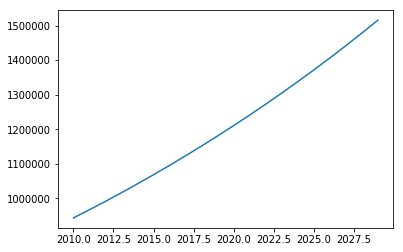

In [110]:
plt.plot(list(range(2010,2030) ), [ hf.GTMuniPopulation(101,y) for y in range(2010,2030)] )
None

In [111]:
notifsRate = casesNotif.reset_index().apply(lambda x: x["Cases Notified_value_m"] / hf.GTMuniPopulation(x.municipality, x.date), 1).iloc[:,0]

In [112]:
notifsRate.index = casesNotif.index.copy()

In [113]:
notifsRate = notifsRate.rename("Case Notification Rate_value_m")

In [114]:
# Mortality Rate_value
vrredis =  pd.read_csv("../../../Outcome Measurement Data/MULTI/VR/vr_redistributed_collapsed_diseases.csv", index_col = 0)

In [115]:
# munis_ids = pd.read_csv("../../Outcome Measurement Data/MULTI/VR/GTM_muni_merges_2009_2016_fixed.csv", index_col = 0)
munis_ids = pd.read_csv("../../../Covariates and Other Data/GIS/GTM_muni_merges_2009_2016_fixed.csv", index_col = 0)

In [116]:
vrredis = vrredis.merge(munis_ids[["adm2_country_code", "adm2_gbd_id"]], left_on= "location_id", right_on="adm2_gbd_id")

In [117]:
mortcounts = vrredis[vrredis.disease.isin(["TB", "TB-VIH"]) & (vrredis.adm2_country_code.notna())]\
.assign(municipality = lambda x: x.adm2_country_code.astype(int), date = lambda x: x.year_id,
        department = lambda x: np.floor(x.adm2_country_code/100).astype(int) ) \
.groupby(["date", "department", "municipality"]).deaths.sum().rename("mortcounts")

In [118]:
mortrate = mortcounts.reset_index().apply(lambda x: x["mortcounts"] / hf.GTMuniPopulation(x.municipality, x.date), 1).iloc[:,0]

In [119]:
mortrate.index = mortcounts.index

In [120]:
mortrate = mortrate.rename("Mortality Rate_value_m")

In [121]:
#  Treatment Success Rate_value
txsrate = pivot_cohortes["COMPLETED TREATMENT"].divide(pivot_cohortes.sum(1))\
.rename_axis(index={"deptocode": "department", "year": "date"}).rename("Treatment Success Rate_value_d")

In [122]:
# HIV/TB Treatment Success Rate_value
pivot_cohortes_tbhiv = cohortes[(cohortes.col_name.isin(["TOTAL"])) & 
       (cohortes.table.isin(["Nuevos TB/VIH"])) &
       (cohortes.deptocode!=0)].\
    groupby(["year", "deptocode", "row_name_B"]).value.sum().unstack(2)
tbhiv_txsrate = pivot_cohortes_tbhiv["COMPLETED TREATMENT"].divide(pivot_cohortes_tbhiv.sum(1))\
.rename_axis(index={"deptocode": "department", "year": "date"}).rename("HIV/TB Treatment Success Rate_value_d")

In [123]:
# HIV/TB Mortality Rate_value
tbhiv_mortrate = vrredis[vrredis.disease.isin(["TB", "TB-VIH"]) & (vrredis.adm2_country_code.notna())]\
.assign(municipality = lambda x: x.adm2_country_code.astype(int), date = lambda x: x.year_id,
        department = lambda x: np.floor(x.adm2_country_code/100).astype(int) ) \
.groupby(["date", "department", "municipality"]).deaths.sum().rename("HIV/TB Mortality Rate_value_m")

In [124]:
# MDR Treatment Success Rate_value
mdrtb.columns

Index(['Unnamed: 0', 'ID', 'X_0', 'Gender', 'Age', 'X_1', 'Muni', 'Depto',
       'DAS', 'PxNew', 'PxRelapse', 'PxLost', 'TxFailure', 'TBType', 'PDSDate',
       'PDSResult', 'X_2', 'X_3', 'TxDate', 'DateBk_1', 'ResultBk_1',
       'DateCulture_1', 'ResultCulture_1', 'DateCulture_2', 'ResultCulture_2',
       'DateCulture_3', 'ResultCulture_3', 'DateCulture_4', 'ResultCulture_4',
       'DateCulture_5', 'ResultCulture_5', 'DateCulture_6', 'ResultCulture_6',
       'DateCulture_7', 'ResultCulture_7', 'DateCulture_8', 'ResultCulture_8',
       'DateCulture_9', 'ResultCulture_9', 'DateCulture_10',
       'ResultCulture_10', 'DateCulture_11', 'ResultCulture_11',
       'DateCulture_12', 'ResultCulture_12', 'DateCulture_13',
       'ResultCulture_13', 'DateCulture_14', 'ResultCulture_14',
       'DateCulture_15', 'ResultCulture_15', 'DateCulture_16',
       'ResultCulture_16', 'DateCulture_17', 'ResultCulture_17',
       'DateCulture_18', 'ResultCulture_18', 'DateCulture_19',
       'Result

In [125]:
mdrtb.ExitCondition.value_counts(dropna=False)

NaN                           86
ambulatorio                   23
FALLECIDO                      7
PERDIDA EN EL SEGUIMIENTO      5
AMBULATORIO                    5
Fallecido                      4
FRACASO                        4
fallecido                      4
FALLECIDA                      3
FUGADO                         2
TX. COMPLETO                   2
PÉRDIDA EN EL SEGUIMIENTO      2
vivo                           2
FALLECIDA                      1
viva                           1
 EGRESO CONTRAINDICADO         1
Fallecida                      1
CONTRAINDICADO                 1
Vivo                           1
ABANDONÓ                       1
Fallecida                      1
Name: ExitCondition, dtype: int64

#### No hay datos confiables de cura de MDR ni de tratamiento completo.
El manual de tx a MDRs menciona que se considera curado a alguien que saca tres pruebas negativas consecutivas. Se puede tomar eso como un proxy de curados.

In [126]:
results = ["ResultCulture_" + str(i) for i in range(1,25)]

In [127]:
resultsdata = mdrtb[results].applymap(lambda x: str(x).lower())\
.applymap(lambda x: \
          "negativo" if "neg" in x else\
          "positivo" if ("pos" in x) or ("+" in x) else\
          "na" if ("cont" in x) or ("no " in x) or (x == "nan") or ("rehus" in x) or ("acid" in x) else x)

In [128]:
pd.unique(resultsdata.values.flatten())

array(['negativo', 'na', 'positivo', '2015-06-24 00:00:00', '1-19 col',
       'pr', '20 colonias', 'nr', '1-19 colonias', 'se verificará envio',
       'según pcte en hrr', '2017-06-21 00:00:00'], dtype=object)

In [129]:
mdrtb["mdrProbCured"] = resultsdata.apply(lambda x:"".join(x.values) , 1).apply(lambda x: x.replace("na", "").strip("-")[-24:] == "negativonegativonegativo")

In [130]:
mdrtb["mdrProbCured"].value_counts()

False    108
True      49
Name: mdrProbCured, dtype: int64

In [131]:
resultsdata.applymap(lambda x: \
          "n" if "negativo" == x else\
          "p" if x == "positivo" else "-").apply(lambda x: "".join(x.values), 1).head()

0    nnnn-n-n-n-n-n-nn--nnnnn
1    nnn--nnn--n-n-n------nn-
2    p-nnnnnn----nn-n--------
3    nnn-nnnnn-n--n-n----n---
4    nnn--nnn--n-n--p-------n
dtype: object

In [132]:
mdrtb.assign(TxYear = lambda x: x.TxDate_Year.astype(str)).groupby(["TxYear", "BD_ID"], observed=False).apply(len)

TxYear  BD_ID   
2009.0  MDR15-17     1
2014.0  MDR14-16    40
2015.0  MDR15-17    33
2016.0  MDR16-18    53
2017.0  MDR16-18     1
nan     MDR14-16     1
        MDR15-17     6
        MDR16-18    22
dtype: int64

In [133]:
mdrtb.BD_ID.value_counts(dropna=False)

MDR16-18    76
MDR14-16    41
MDR15-17    40
Name: BD_ID, dtype: int64

In [134]:
mdrcx = mdrtb.assign(date = lambda x: x.Year+2000).groupby(["date", "deptocode"]).mdrProbCured.apply(lambda x: x.sum() / len(x) if len(x)>0 else 0)\
.rename_axis(index={"deptocode": "department"}).rename("MDR Probably Cured_rate_d")

In [135]:
mdrcx

date  department
2014  1.0           0.571429
      2.0           1.000000
      5.0           0.615385
      9.0           0.000000
      10.0          0.600000
      11.0          0.000000
      12.0          0.875000
      13.0          1.000000
      17.0          0.000000
2015  1.0           0.250000
      5.0           0.111111
      9.0           0.333333
      10.0          0.333333
      11.0          0.500000
      12.0          0.666667
      13.0          0.250000
      15.0          0.000000
      18.0          0.500000
      21.0          0.000000
      22.0          0.000000
2016  1.0           0.250000
      3.0           0.000000
      5.0           0.214286
      7.0           0.000000
      8.0           0.000000
      9.0           0.000000
      10.0          0.333333
      11.0          0.000000
      12.0          0.086957
      13.0          0.000000
      14.0          0.000000
      16.0          0.000000
      17.0          0.000000
      18.0          0.3333

In [137]:
impact = pd.merge(makeFullIndex(notifsRate), makeFullIndex(mortrate), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(txsrate), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(tbhiv_txsrate), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(tbhiv_mortrate), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(mdrcx), left_index=True, right_index=True, how="outer")\
            

In [142]:
impact.to_csv("impact.csv")

# Outcomes

* Proportion of Cases Treated_value
* Proportion of Cases in Prisons Treated_value
* Proportion of HIV/TB Cases Treated_value
* Proportion of TB Patients who Received HIV Test_value
* ~~Proportion of New HIV Patients Starting IPT_value~~
* Proportion of MDR Cases Treated_value
* Proportion of Patients Receiving DST_value
* ~~Proportion of MDR Cases completing at least 6 mo of therapy_value~~

In [143]:
(initiatedTx / casesNotif.reset_index().groupby(["date", "department"])["Cases Notified_value_m"].sum()).describe()

count    110.000000
mean       0.838249
std        0.195957
min        0.345455
25%        0.729299
50%        0.820123
75%        0.932506
max        1.769231
dtype: float64

In [144]:
# FechaInicioTx <= 4 indica fechas inválidas o no disponibles
notifs.FECHAINICIOTX[notifs.FECHAINICIOTX.map(lambda x: len(str(x))<=4)].unique()

array(['ND', 'nd', nan, 'NR', '…', '….', 'MD', 'NRND', 'NE', 'N'],
      dtype=object)

In [145]:
initTxNotifs = notifs[ notifs.FECHAINICIOTX.map(lambda x: len(str(x))<=4) &
                     (notifs.Year<2018) & 
                     notifs.COD_MUNI.notna()].assign(municipality = lambda x: x.COD_MUNI.astype(int)).assign(date=lambda x: x.Year.astype(int))\
        .assign(department = lambda x: (np.floor(x.COD_MUNI/100)).astype(int) )\
        .groupby(["date", "department", "municipality"]).apply(len)

In [146]:
initTxNotifs = initTxNotifs[initTxNotifs.index.get_level_values(1)!=0].fillna(0)

In [147]:
propCasesTx =  (initTxNotifs / casesNotif).rename("Proportion of Cases Treated_value_m")

In [148]:
# Proportion of Cases in Prisons Treated_value
propPPLTx = (ppltx / pplcases["Cases Notified in Prisons_value"]).rename("Proportion of Cases in Prisons Treated_value_d")

In [149]:
# Proportion of HIV/TB Cases Treated_value
temp = notifs[(notifs.FECHAINICIOTX.map(lambda x: len(str(x))<=4)) & (notifs.VIH == "Reactive") & (notifs.Year<2018) & notifs.COD_MUNI.notna()]\
.assign(municipality = lambda x: x.COD_MUNI.astype(int)).assign(date=lambda x: x.Year.astype(int))\
.assign(department = lambda x: (np.floor(x.COD_MUNI/100)).astype(int) ).groupby(["date", "department", "municipality"]).apply(len)

propHIVTx = (temp / hivcases).rename("Proportion of HIV/TB Cases Treated_value_m")

In [180]:
# Proportion of TB Patients who Received HIV Test_value
propTbHivDx = (tbhivTx / casesNotif.reindex(tbhivTx.index)).rename("Proportion of TB Patients who Received HIV Test_value")

In [151]:
propHivIPT = \
sicoinRM[(sicoinRM.Programa == "16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA") &
sicoinRM.Resultado.isin(
       ['6.0-Paciente VIH positivo, con prueba diagnóstica de tuberculosis',
       '6.0-Pacientes VIH positivos, con prueba diagnostica de Tuberculosis']
) & (sicoinRM.LugarEjecutado.notna())].assign(date = lambda x: x.Year, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["date", "department", "municipality"]).LugarEjecutado.sum()\
.rename("PLHIV Screened for TB_value_m")


In [152]:
# Proportion of New HIV Patients Starting IPT_value
# HIV with IPT :  plhivipt

In [153]:
sicoinRM[(sicoinRM.Programa == "16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA") &
        sicoinRM.Resultado.isin([      '8.0-Paciente VIH positivo con tratamiento ARV'
                                 #'1.0-Persona con diagnóstico y tratamiento de ITS, VIH/SIDA'
                                ]) &
        sicoinRM.LugarCod.isna()]

,Unnamed: 0,Programa,Subprograma,Proyecto,ActOb,Resultado,LugarCod,LocationNombre,Unidades,Inicial,Vigente,LugarEjecutado,Ejecutado,PorcEj,NBeneficiados,Year,Reporte_Programa
1399,1399,"16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA",00-SIN SUBPROGRAMA,000-SIN PROYECTO,002-000-PERSONA CON DIAGNÓSTICO Y TRATAMIENTO ...,8.0-Paciente VIH positivo con tratamiento ARV,NaN,Paciente VIH positivo con tratamiento ARV,Persona,70496.0,64629.0,NaN,48188.0,74.56,0.0,2017,"ENTIDAD = 11130009, PROGRAMA = 16"
10111,10111,"16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA",00-SIN SUBPROGRAMA,000-SIN PROYECTO,002-000-PERSONA CON DIAGNÓSTICO Y TRATAMIENTO ...,8.0-Paciente VIH positivo con tratamiento ARV,NaN,Paciente VIH positivo con tratamiento ARV,Persona,70496.0,73132.0,NaN,60663.0,82.95,0.0,2018,"ENTIDAD = 11130009, PROGRAMA = 16"


In [154]:
# There is no data on how many new HIV cases have been found
# sicoinRM[(sicoinRM.Programa == "16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA")].Resultado.unique()

In [155]:
# Proportion of MDR Cases Treated_value
propMDRTx = ( mdrtx/mdrcases).rename("Proportion of MDR Cases Treated_value_d")

In [156]:
# Proportion of Patients Receiving DST_value
notifs.columns.values

array(['NOMBRES', 'DIRECCION', 'MUNICIPIO', 'DEPARTAMENTO',
       'SERVICIODESALUD', 'SEXO', 'EDAD', 'RANGOEDAD', 'PESOLBS',
       'PESOKG', 'CONDICIONINGRESO', 'FECHANOTIFICACION', 'FECHAINICIOTX',
       'CLASIFICACION', 'VIH', 'ESQUEMA', 'CONTACTOS', 'OTRASPATOLOGIAS',
       'YEAR', 'YearMonth', 'TIPODETBPEDIATRICOS', 'FECHAPRUEBAVIH',
       'CONDICIONEGRESO', 'FECHAMUERTE', 'CAUSADEMUERTE',
       'PACIENTEPRIVADOLIBERTAD', 'DEPORTADO', 'LOCALIZACIONTB',
       'METODODX', 'CONTACTO_000_014', 'CONTACTO_MAYORA_015',
       'CASOINDICE', 'DESARROLLOTBCLASIFICACION', 'EMPLEADOMSPAS',
       'UNIDADDX', 'FALLECIDOS', 'CORRELATIVO', 'DAS', 'FECHANACIMIENTO',
       'FECHAACTUAL', 'EDADDECADA', 'EDUCACION', 'PUEBLO', 'OCUPACION',
       'NUEVACONDICIONINGRESO', 'FECHADX', 'NUEVOMETODODX', 'PDS',
       'CONTACTO_000_0004', 'CONTACTO_MAYORA_005', 'QUIMIO_VIH',
       'DBCATEGORY', 'DISTRITO', 'MIGRACION', 'CONDICIONPX',
       'CAUSAMUERTE', 'TipoTB', 'MESNOTIFICACION', 'OTRASPATOLOGI

In [157]:
casespds = notifs[ (notifs.FECHAPDS.map(lambda x: len(str(x))>4) | notifs.PDS.notna() | notifs.RESULTADOPDS.notna()) & 
        (notifs.Year<2018) & notifs.COD_MUNI.notna()
      ].assign(municipality = lambda x: x.COD_MUNI).assign(date=lambda x: x.Year.astype(int))\
        .assign(department = lambda x: (np.floor(x.COD_MUNI/100)).astype(int) )\
        .groupby(["date", "department", "municipality"]).apply(len)

In [158]:
notifs.PDS.value_counts()

SI                     382
SENSIBLE               117
RESISTENTE INH          12
CONTAMINADO              6
RESISTENTE R             4
RR                       4
RESISTENTE INH,R         3
MDR                      2
NO CRECIO                1
MONORESISTE A INH        1
RESISTENTE INH, STR      1
ND                       1
ACIDIFICADO              1
REISTENTE A R            1
ACIDIFICADA              1
Name: PDS, dtype: int64

In [159]:
casespds.sum()

486

In [160]:
propDST = (casespds/casesNotif).fillna(0).rename("Proportion of Patients Receiving DST_value_m")

In [161]:
# Proportion of MDR Cases completing at least 6 mo of therapy_value

In [162]:
# There is no information about Tx duration

In [181]:
outcomes = pd.merge(makeFullIndex(propCasesTx), makeFullIndex(propPPLTx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(propHIVTx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(propTbHivDx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(propMDRTx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(propDST), left_index=True, right_index=True, how="outer")\
            

In [182]:
outcomes.head()

Proportion of Cases Treated_value_m  \
date department municipality                                        
2012 1          101                                      0.415094   
                102                                      0.600000   
                103                                      0.400000   
                104                                           NaN   
                105                                      0.750000   

                              Proportion of Cases in Prisons Treated_value_d  \
date department municipality                                                   
2012 1          101                                                      NaN   
                102                                                      NaN   
                103                                                      NaN   
                104                                                      NaN   
                105                                                      NaN   

                              Proportion of HIV/TB Cases Treated_value_m  \
date department municipality                                               
2012 1          101                                             0.290323   
                102                                             0.000000   
                103                                             0.333333   
                104                                                  NaN   
                105                                             0.000000   

                              Proportion of TB Patients who Received HIV Test_value  \
date department municipality                                                          
2012 1          101                                                         NaN       
                102                                                         NaN       
                103                                                         NaN       
                104                                                         NaN       
                105                                                         NaN       

                              Proportion of MDR Cases Treated_value_d  \
date department municipality                                            
2012 1          101                                               NaN   
                102                                               NaN   
                103                                               NaN   
                104                                               NaN   
                105                                               NaN   

                              Proportion of Patients Receiving DST_value_m  
date department municipality                                                
2012 1          101                                                    0.0  
                102                                                    0.0  
                103                                                    0.0  
                104                                                    0.0  
                105                                                    0.0

In [184]:
outcomes.to_csv("outcomes.csv")

In [167]:
propTbHivDx

date  department  municipality
2012  1           101.0          NaN
                  102.0          NaN
                  103.0          NaN
                  104.0          NaN
                  105.0          NaN
                  106.0          NaN
                  107.0          NaN
                  108.0          NaN
                  109.0          NaN
                  110.0          NaN
                  111.0          NaN
                  113.0          NaN
                  114.0          NaN
                  115.0          NaN
                  116.0          NaN
                  117.0          NaN
      2           201.0          NaN
                  203.0          NaN
                  205.0          NaN
                  206.0          NaN
                  207.0          NaN
      3           301.0          NaN
                  304.0          NaN
                  305.0          NaN
                  306.0          NaN
                  310.0          NaN
       